In [1]:
import re
import os
import numpy as np
import torch
import time
from torch.optim import Adam
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms
from torchvision import models
import torch.onnx
from PIL import Image
from collections import namedtuple
import matplotlib.pyplot as plt

In [2]:
# utility functions

# load image with optional size or scale
def load_image(filename, size=None, scale=None):
    img = Image.open(filename)
    if size is not None:
        img = img.resize((size, size), Image.ANTIALIAS)
    elif scale is not None:
        img = img.resize((int(img.size[0] / scale), int(img.size[1] / scale)), Image.ANTIALIAS)
    return img

# save image
def save_image(filename, data):
    img = data.clone().clamp(0, 255).numpy()
    img = img.transpose(1, 2, 0).astype("uint8")
    img = Image.fromarray(img)
    img.save(filename)

# return gram matrix of input layer outputs
def gram_matrix(y):
    (b, ch, h, w) = y.size()
    features = y.view(b, ch, w * h)
    features_t = features.transpose(1, 2)
    # compute gram product
    gram = features.bmm(features_t) / (ch * h * w)
    return gram


def normalize_batch(batch):
    # normalize using imagenet mean and std. normalize so we can easily put it in a nn.Sequential
    # allows to work with image Tenor of shape
    mean = batch.new_tensor([0.485, 0.456, 0.406]).view(-1, 1, 1)
    std = batch.new_tensor([0.229, 0.224, 0.225]).view(-1, 1, 1)
    batch = batch.div_(255.0)
    return (batch - mean) / std



In [3]:
# image transformer network
class TransformerNet(torch.nn.Module):
    # method described in https://arxiv.org/abs/1603.08155 and https://arxiv.org/pdf/1607.08022.pdf
    def __init__(self):
        super(TransformerNet, self).__init__()
        # Initial convolution layers
        self.conv1 = ConvLayer(3, 32, kernel_size=9, stride=1)
        self.in1 = torch.nn.InstanceNorm2d(32, affine=True)
        self.conv2 = ConvLayer(32, 64, kernel_size=3, stride=2)
        self.in2 = torch.nn.InstanceNorm2d(64, affine=True)
        self.conv3 = ConvLayer(64, 128, kernel_size=3, stride=2)
        self.in3 = torch.nn.InstanceNorm2d(128, affine=True)
        # Residual layers
        self.res1 = ResidualBlock(128)
        self.res2 = ResidualBlock(128)
        self.res3 = ResidualBlock(128)
        self.res4 = ResidualBlock(128)
        self.res5 = ResidualBlock(128)
        # Upsampling Layers
        self.deconv1 = UpsampleConvLayer(128, 64, kernel_size=3, stride=1, upsample=2)
        self.in4 = torch.nn.InstanceNorm2d(64, affine=True)
        self.deconv2 = UpsampleConvLayer(64, 32, kernel_size=3, stride=1, upsample=2)
        self.in5 = torch.nn.InstanceNorm2d(32, affine=True)
        self.deconv3 = ConvLayer(32, 3, kernel_size=9, stride=1)
        # Non-linearities
        self.relu = torch.nn.ReLU()

    def forward(self, X):
        y = self.relu(self.in1(self.conv1(X)))
        y = self.relu(self.in2(self.conv2(y)))
        y = self.relu(self.in3(self.conv3(y)))
        y = self.res1(y)
        y = self.res2(y)
        y = self.res3(y)
        y = self.res4(y)
        y = self.res5(y)
        y = self.relu(self.in4(self.deconv1(y)))
        y = self.relu(self.in5(self.deconv2(y)))
        y = self.deconv3(y)
        return y


class ConvLayer(torch.nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride):
        super(ConvLayer, self).__init__()
        reflection_padding = kernel_size // 2
        self.reflection_pad = torch.nn.ReflectionPad2d(reflection_padding)
        self.conv2d = torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride)

    def forward(self, x):
        out = self.reflection_pad(x)
        out = self.conv2d(out)
        return out


class ResidualBlock(torch.nn.Module):
    # ResidualBlock introduced in: https://arxiv.org/abs/1512.03385
    # recommended architecture: http://torch.ch/blog/2016/02/04/resnets.html


    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = ConvLayer(channels, channels, kernel_size=3, stride=1)
        self.in1 = torch.nn.InstanceNorm2d(channels, affine=True)
        self.conv2 = ConvLayer(channels, channels, kernel_size=3, stride=1)
        self.in2 = torch.nn.InstanceNorm2d(channels, affine=True)
        self.relu = torch.nn.ReLU()

    def forward(self, x):
        residual = x
        out = self.relu(self.in1(self.conv1(x)))
        out = self.in2(self.conv2(out))
        out = out + residual
        return out


class UpsampleConvLayer(torch.nn.Module):
    # UpsampleConvLayer Upsamples the input and then does a convolution. This method gives better results
    # compared to ConvTranspose2d. ref: http://distill.pub/2016/deconv-checkerboard/

    def __init__(self, in_channels, out_channels, kernel_size, stride, upsample=None):
        super(UpsampleConvLayer, self).__init__()
        self.upsample = upsample
        if upsample:
            self.upsample_layer = torch.nn.Upsample(mode='nearest', scale_factor=upsample)
        reflection_padding = kernel_size // 2
        self.reflection_pad = torch.nn.ReflectionPad2d(reflection_padding)
        self.conv2d = torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride)

    def forward(self, x):
        x_in = x
        if self.upsample:
            x_in = self.upsample_layer(x_in)
        out = self.reflection_pad(x_in)
        out = self.conv2d(out)
        return out

In [4]:
# vgg16 pretrained image model
class Vgg16(torch.nn.Module):
    def __init__(self, requires_grad=False):
        super(Vgg16, self).__init__()
        vgg_pretrained_features = models.vgg16(pretrained=True).features
        self.slice1 = torch.nn.Sequential()
        self.slice2 = torch.nn.Sequential()
        self.slice3 = torch.nn.Sequential()
        self.slice4 = torch.nn.Sequential()
        for x in range(4):
            self.slice1.add_module(str(x), vgg_pretrained_features[x])
        for x in range(4, 9):
            self.slice2.add_module(str(x), vgg_pretrained_features[x])
        for x in range(9, 16):
            self.slice3.add_module(str(x), vgg_pretrained_features[x])
        for x in range(16, 23):
            self.slice4.add_module(str(x), vgg_pretrained_features[x])
        if not requires_grad:
            for param in self.parameters():
                param.requires_grad = False

    def forward(self, X):
        h = self.slice1(X)
        h_relu1_2 = h
        h = self.slice2(h)
        h_relu2_2 = h
        h = self.slice3(h)
        h_relu3_3 = h
        h = self.slice4(h)
        h_relu4_3 = h
        vgg_outputs = namedtuple("VggOutputs", ['relu1_2', 'relu2_2', 'relu3_3', 'relu4_3'])
        out = vgg_outputs(h_relu1_2, h_relu2_2, h_relu3_3, h_relu4_3)
        return out

In [5]:
# check if we can use a gpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
# desired size of the output image
imsize = 512 if torch.cuda.is_available() else 128 
print(imsize)

512


In [7]:
# RUN ONLY IF training a model

# random seed for training
np.random.seed(42)
torch.manual_seed(42)
    
transform = transforms.Compose([
        # INPUT size of training images, default is 256
        transforms.Resize(256),
        transforms.CenterCrop(256),
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.mul(255))
    ])
# INPUT path to training dataset, path shold point to a folder 
# containing another folder with lal the training images
train_dataset = datasets.ImageFolder("dataset", transform)

# INPUT bath size, default is 4
train_loader = DataLoader(train_dataset, batch_size=4)

transformer = TransformerNet().to(device)
# INPUT learning rate, default is 1e-3
optimizer = Adam(transformer.parameters(), 1e-3)
mse_loss = torch.nn.MSELoss()

vgg = Vgg16(requires_grad=False).to(device)
style_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.mul(255))
    ])
# INPUT, style image that you want to make a model of
# INPUT, style image size you want to train with, default is original/none
style = load_image("styles/bullfight.jpg", size=None)
style = style_transform(style)
# INPUT, batch size for training, default is 4
style = style.repeat(4, 1, 1, 1).to(device)

features_style = vgg(normalize_batch(style))
gram_style = [gram_matrix(y) for y in features_style]

# INPUT, number of epochs for training, default is 2
for e in range(2):
    transformer.train()
    agg_content_loss = 0.
    agg_style_loss = 0.
    count = 0
    for batch_id, (x, _) in enumerate(train_loader):
        n_batch = len(x)
        count += n_batch
        optimizer.zero_grad()

        x = x.to(device)
        y = transformer(x)

        y = normalize_batch(y)
        x = normalize_batch(x)

        features_y = vgg(y)
        features_x = vgg(x)
        # INPUT, weight for content-loss, default is 1e5
        content_loss = 1e5 * mse_loss(features_y.relu2_2, features_x.relu2_2)

        style_loss = 0.
        for ft_y, gm_s in zip(features_y, gram_style):
            gm_y = gram_matrix(ft_y)
            style_loss += mse_loss(gm_y, gm_s[:n_batch, :, :])
        # INPUT, weight for style-loss, default is 1e10
        style_loss *= 1e10

        total_loss = content_loss + style_loss
        total_loss.backward()
        optimizer.step()

        agg_content_loss += content_loss.item()
        agg_style_loss += style_loss.item()

        # INPUT, number of images after which the training loss is logged, default is 500
        if (batch_id + 1) % 500 == 0:
            mesg = "{}\tEpoch {}:\t[{}/{}]\tcontent: {:.6f}\tstyle: {:.6f}\ttotal: {:.6f}".format(
                time.ctime(), e + 1, count, len(train_dataset),
                              agg_content_loss / (batch_id + 1),
                              agg_style_loss / (batch_id + 1),
                              (agg_content_loss + agg_style_loss) / (batch_id + 1)
            )
            print(mesg)


# save model
transformer.eval().cpu()
# INPUT, num epochs, content weight, and style weight for naming purposes
save_model_filename = "80000_epoch_" + str(2) + "_" + str(time.ctime()).replace(' ', '_') + "_" + str(
    1e5) + "_" + str(1e10) + ".model"
# INPUT, path to directory to save models
save_model_path = os.path.join("models", save_model_filename)
torch.save(transformer.state_dict(), save_model_path)

print("\nDone, trained model saved at", save_model_path)

Thu Aug  9 20:57:54 2018	Epoch 1:	[2000/82783]	content: 1126418.022438	style: 3492894.829250	total: 4619312.851688
Thu Aug  9 21:04:22 2018	Epoch 1:	[4000/82783]	content: 1149783.925406	style: 2049709.446437	total: 3199493.371844
Thu Aug  9 21:10:49 2018	Epoch 1:	[6000/82783]	content: 1130825.829854	style: 1513740.448104	total: 2644566.277958
Thu Aug  9 21:17:17 2018	Epoch 1:	[8000/82783]	content: 1103768.012078	style: 1229783.086266	total: 2333551.098344
Thu Aug  9 21:23:44 2018	Epoch 1:	[10000/82783]	content: 1075073.622788	style: 1053241.773850	total: 2128315.396637
Thu Aug  9 21:30:11 2018	Epoch 1:	[12000/82783]	content: 1047683.473010	style: 931353.035672	total: 1979036.508682
Thu Aug  9 21:36:38 2018	Epoch 1:	[14000/82783]	content: 1023334.202330	style: 843245.640746	total: 1866579.843076
Thu Aug  9 21:43:06 2018	Epoch 1:	[16000/82783]	content: 1001435.882898	style: 776093.568578	total: 1777529.451477
Thu Aug  9 21:49:34 2018	Epoch 1:	[18000/82783]	content: 981714.675729	style: 7

Fri Aug 10 04:51:35 2018	Epoch 2:	[66000/82783]	content: 661072.356765	style: 232883.744369	total: 893956.101134
Fri Aug 10 04:58:02 2018	Epoch 2:	[68000/82783]	content: 660836.483184	style: 232709.869983	total: 893546.353167
Fri Aug 10 05:04:30 2018	Epoch 2:	[70000/82783]	content: 660630.777229	style: 232526.138833	total: 893156.916062
Fri Aug 10 05:10:57 2018	Epoch 2:	[72000/82783]	content: 660360.792024	style: 232382.364130	total: 892743.156155
Fri Aug 10 05:17:24 2018	Epoch 2:	[74000/82783]	content: 660077.005784	style: 232214.989943	total: 892291.995726
Fri Aug 10 05:23:51 2018	Epoch 2:	[76000/82783]	content: 659876.340878	style: 232055.454687	total: 891931.795566
Fri Aug 10 05:30:18 2018	Epoch 2:	[78000/82783]	content: 659513.952856	style: 231869.114345	total: 891383.067201
Fri Aug 10 05:36:46 2018	Epoch 2:	[80000/82783]	content: 659235.313972	style: 231716.041875	total: 890951.355847
Fri Aug 10 05:43:13 2018	Epoch 2:	[82000/82783]	content: 659043.269643	style: 231583.776623	tota

In [13]:
# Run if stylizing an image

# INPUT path to content image
content_image = load_image("nameToSaveAsToLocal.png", scale=None)
content_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.mul(255))
])
content_image = content_transform(content_image)
content_image = content_image.unsqueeze(0).to(device)
with torch.no_grad():
    style_model = TransformerNet()
    # INPUT, model you want to stylize with
    state_dict = torch.load("models/starry_night.model")
    # remove saved deprecated running_* keys in InstanceNorm from the checkpoint
    for k in list(state_dict.keys()):
        if re.search(r'in\d+\.running_(mean|var)$', k):
            del state_dict[k]
    style_model.load_state_dict(state_dict)
    style_model.to(device)
    output = style_model(content_image).cpu()
save_image("my_test.jpg", output[0])


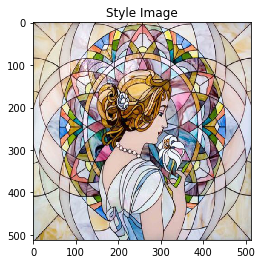

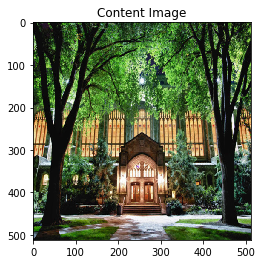

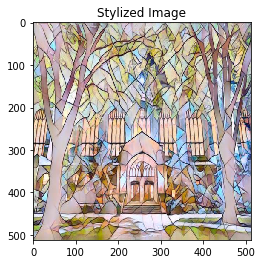

In [13]:
# Run to show our results

unloader = transforms.ToPILImage()  # reconvert into PIL image

plt.ion()

loader = transforms.Compose([
    transforms.Resize((imsize,imsize)),  # scale imported image
    transforms.ToTensor()])  # transform it into a torch tensor


def image_loader(image_name):
    image = Image.open(image_name)
    # fake batch dimension required to fit network's input dimensions
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)

def imshow(tensor, title=None):
    image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
    image = image.squeeze(0)      # remove the fake batch dimension
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # pause a bit so that plots are updated

# INPUT: style image path
style_img = image_loader("mosaic.jpg")

# INPUT: content image path
content_img = image_loader("law_library.jpg")

# INPUT: stylized image path
stylized_img = image_loader("my_test.jpg")

plt.figure()
imshow(style_img, title='Style Image')

plt.figure()
imshow(content_img, title='Content Image')

plt.figure()
imshow(stylized_img, title='Stylized Image')